In [50]:
from pyspark.sql import SparkSession
from vars import *
from datetime import date
from functions import loadConfigs
from delta import *
from pyspark.sql.functions import current_date
from pyspark.sql.functions import month, year
from columns import awardings
from pyspark.sql.functions import col, explode

builder = loadConfigs(SparkSession.builder)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

today = date.today().strftime('%Y%m%d')
# today = 20230326

output_file = "awardings"

top_subreddits = spark.read.format("delta").load(f"s3a://{minio_bucket}/gold/gildings/top_subreddits")

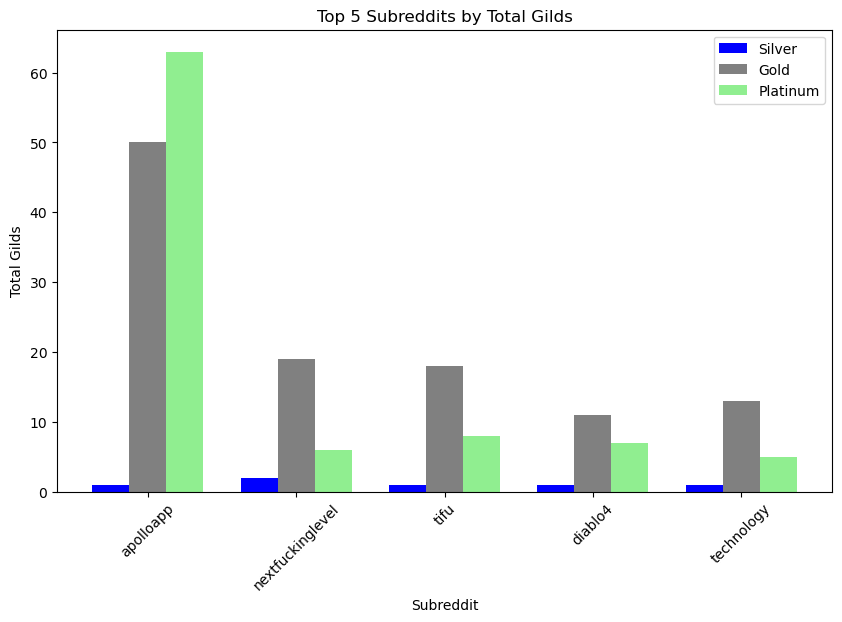

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = top_subreddits.toPandas()

subreddit_gilds = pandas_df.groupby('subreddit')[['total_silver_gilds', 'total_gold_gilds', 'total_platinum_gilds']].sum()
subreddit_gilds['total_gilds'] = subreddit_gilds.sum(axis=1)

top_5_subreddits = subreddit_gilds.nlargest(5, 'total_gilds')

colors = ['blue', 'grey', 'lightgreen']

bar_width = 0.25
index = np.arange(len(top_5_subreddits))

plt.figure(figsize=(10, 6))
plt.bar(index, top_5_subreddits['total_silver_gilds'], width=bar_width, color=colors[0], label='Silver')
plt.bar(index + bar_width, top_5_subreddits['total_gold_gilds'], width=bar_width, color=colors[1], label='Gold')
plt.bar(index + 2 * bar_width, top_5_subreddits['total_platinum_gilds'], width=bar_width, color=colors[2], label='Platinum')

plt.title('Top 5 Subreddits by Total Gilds')
plt.xlabel('Subreddit')
plt.ylabel('Total Gilds')

plt.xticks(index + bar_width, top_5_subreddits.index, rotation=45)
plt.legend()

plt.show()

In [52]:
top_authors = spark.read.format("delta").load(f"s3a://{minio_bucket}/gold/awardings/top_authors")

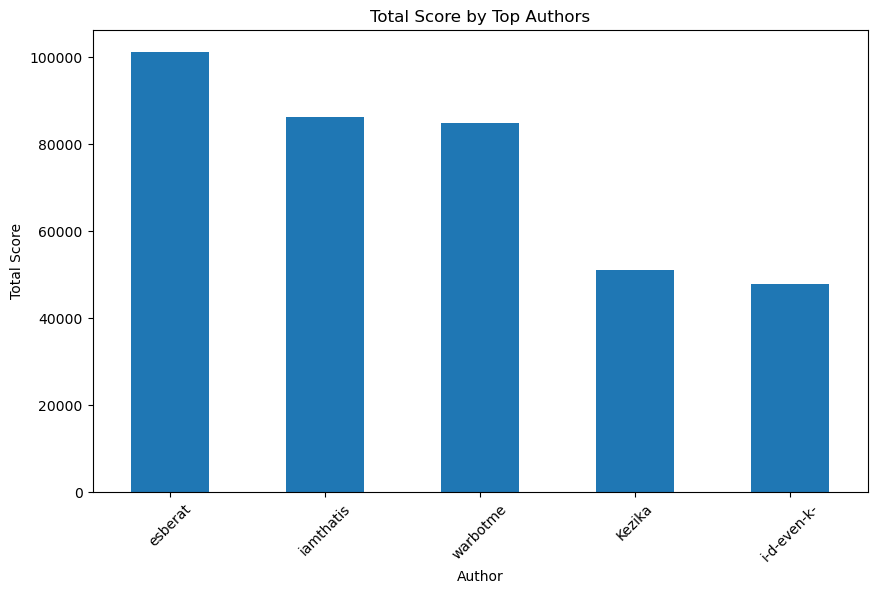

In [53]:
from pyspark.sql import functions as F

top_authors = top_authors.groupBy('year', 'month', 'author').agg(F.first('score').alias('score'))
pandas_df = top_authors.toPandas()
author_df = pandas_df.groupby('author')['score'].sum().nlargest(5)

plt.figure(figsize=(10, 6))
author_df.plot(kind='bar')

plt.title('Total Score by Top Authors')
plt.xlabel('Author')
plt.ylabel('Total Score')

plt.xticks(rotation=45)
plt.legend().remove()

plt.show()